# Imports 

In [28]:
from __future__ import print_function
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import warnings
warnings.filterwarnings('ignore')

In [29]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: True


# Load Dataset
WELFake from HuggingFace

In [48]:
from datasets import load_dataset

#load my test set embeddings first, change later
dataset = load_dataset("Paulozs/WELFake_embeddings")
print(dataset)

Generating train split: 100%|██████████| 62592/62592 [00:02<00:00, 31054.30 examples/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'label', 'roberta_embedding', 'bow_embedding', 'tfidf_embedding', 'w2v_embedding'],
        num_rows: 62592
    })
})


## Split dataset

In [49]:
#convert dataset to pandas for easier implementation with sklearn

df = dataset["train"].to_pandas()
display(df)

,title,text,label,roberta_embedding,bow_embedding,tfidf_embedding,w2v_embedding
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,"[0.77837825, -1.3829339, 0.21932077, -0.037815...","[12.751228183014527, -8.760484977091297, -2.46...","[0.3186029772902578, -0.1094107173745029, 0.10...","[0.005737772, 0.051631283, 0.039275542, 0.0679..."
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,"[-3.4394891, -1.1532453, -0.57524085, -0.29689...","[0.1540906344076637, -0.06480693954115654, -0....","[0.07578831287738759, -0.015240886953002832, 0...","[0.014999917, 0.057231702, 0.05448833, 0.10918..."
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"[0.61816597, 0.10020125, -0.627897, -0.1652965...","[11.144724982986332, -6.606145662614691, -0.79...","[0.3980779078413261, -0.15109853445516602, 0.0...","[0.04940245, 0.03809506, 0.030635785, 0.096523..."
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"[0.6582862, 0.40051103, -0.35593724, 0.6198630...","[2.6159286882160537, -1.72675977752399, -0.519...","[0.21115011222058097, -0.14267633316979805, -0...","[-0.022517398, 0.08829837, 0.06998471, 0.05531..."
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,"[0.51393855, 0.6349008, 1.0849333, 0.33767414,...","[1.9346475297557924, -1.1505992523835311, -0.7...","[0.1945931561404842, -0.1142489399938969, 0.00...","[0.031655375, 0.018008867, 0.039424133, 0.0783..."
...,...,...,...,...,...,...,...
62587,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,An email released by WikiLeaks on Sunday appea...,1,"[-0.74468505, 0.1229167, 1.3666742, 0.07904005...","[3.622973638522903, -0.54198912841281, -1.4584...","[0.23084806769137872, 0.09422806198766091, 0.3...","[-0.00035927512, 0.04827896, -0.027950248, 0.0..."
62588,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,"[0.5316571, 0.9854491, -0.6684599, -0.01448869...","[17.799926846744107, 1.1087862440581235, 1.350...","[0.4787758131172253, 0.003986352099122974, -0....","[-0.020597927, 0.025891328, 0.0079015875, 0.06..."
62589,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,"[0.6461022, -1.1085404, 0.13549614, -0.3637871...","[16.499211522306364, 13.110890533481918, -1.99...","[0.45380863043849157, 0.3371814687589905, -0.0...","[0.026168875, 0.059571818, 0.025066013, 0.0854..."
62590,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,"[0.5340885, -0.03433156, -0.3962021, 0.1179680...","[5.264526534165657, -3.8853342501017916, -0.87...","[0.290404249417728, -0.21906293500944446, -0.0...","[0.009088822, 0.061462272, 0.026323821, 0.0745..."


## TF-IDF Embedding

In [50]:
from sklearn.model_selection import train_test_split

seed = 45

y = df["label"]
x = df["tfidf_embedding"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

print(x_train, y_train)

6312     [0.2913193475178382, -0.25964890109450217, -0....
1575     [0.3458007493067191, 0.1488610801652892, -0.09...
34150    [0.22471385300739916, -0.21535486255894393, 0....
20440    [0.21976064678214624, -0.04813982501158199, -0...
49987    [0.36752246000471256, -0.17607963257083178, -0...
                               ...                        
12895    [0.20483901494858434, -0.04508991069278617, 0....
60960    [0.296419404864837, -0.04091803082821383, 0.07...
6012     [0.10656974408814512, -0.02633602960051711, 0....
6558     [0.2775299676755072, -0.1994376435245847, 0.12...
56267    [0.2667877512487862, 0.06728728052018784, 0.26...
Name: tfidf_embedding, Length: 50073, dtype: object 6312     1
1575     1
34150    0
20440    0
49987    0
        ..
12895    1
60960    1
6012     1
6558     0
56267    1
Name: label, Length: 50073, dtype: int64


### Training

no further preprocessing

In [51]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [52]:
print(x_train.shape)
print(x_train[0].shape)

(50073,)
(300,)


In [53]:
import numpy as np

x_train_fixed = np.stack(x_train)  
x_test_fixed = np.stack(x_test)
print(x_train_fixed.shape)  
print(x_test_fixed.shape)

(50073, 300)
(12519, 300)


In [54]:
#instantiate with default params first
rf = RandomForestClassifier(random_state=seed)

## Hyperparameter tuning

In [55]:
#randomizedsearchcv - includes cross validation
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {'n_estimators': randint(50,150),
              'max_depth': randint(3,15)}


# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=20, 
                                 cv=5,
                                 n_jobs=-1,
                                 random_state=seed)

# Fit the random search object to the data
rand_search.fit(x_train_fixed, y_train)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=45),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A3BBAC76B0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A3BBAF22D0>},
                   random_state=45)

In [56]:
# Create a variable for the best model
tfidf_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 14, 'n_estimators': 125}


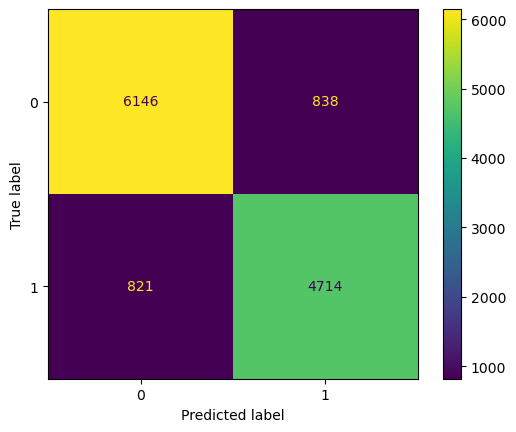

In [57]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
# Generate predictions with the best model
y_pred = tfidf_rf.predict(x_test_fixed)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [58]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8674814282290918
Precision: 0.8490634005763689
Recall: 0.8516711833785005


## BOW Embedding

In [44]:
x = df["bow_embedding"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

x_train_fixed = np.stack(x_train)  
x_test_fixed = np.stack(x_test)
print(x_train_fixed.shape)  
print(x_test_fixed.shape)

(5520, 300)
(1380, 300)


In [45]:
rand_search.fit(x_train_fixed, y_train)

# Create a variable for the best model
bow_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 12, 'n_estimators': 111}


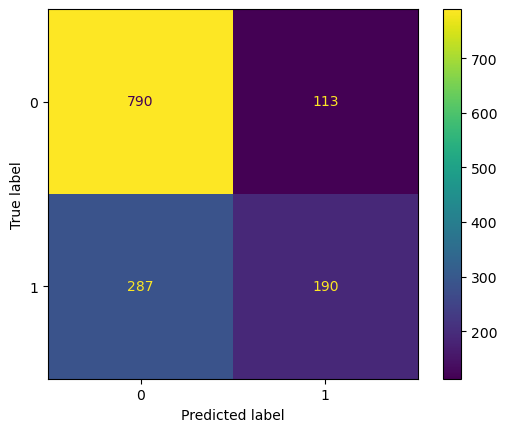

In [46]:
y_pred = bow_rf.predict(x_test_fixed)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [47]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7101449275362319
Precision: 0.6270627062706271
Recall: 0.39832285115303984


## CBOW-W2V

In [60]:
x = df["w2v_embedding"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

x_train_fixed = np.stack(x_train)  
x_test_fixed = np.stack(x_test)
print(x_train_fixed.shape)  
print(x_test_fixed.shape)

(50073, 300)
(12519, 300)


In [61]:
rand_search.fit(x_train_fixed, y_train)

# Create a variable for the best model
w2v_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 14, 'n_estimators': 125}


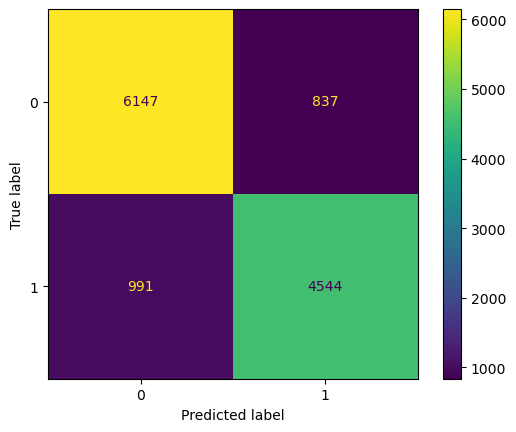

In [62]:
y_pred = w2v_rf.predict(x_test_fixed)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [63]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8539819474398914
Precision: 0.844452703958372
Recall: 0.8209575429087624


## roBERTa (Iter 4)

In [65]:
x = df["roberta_embedding"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

x_train_fixed = np.stack(x_train)  
x_test_fixed = np.stack(x_test)
print(x_train_fixed.shape)  
print(x_test_fixed.shape)

(50073, 300)
(12519, 300)


In [66]:
rand_search.fit(x_train_fixed, y_train)

# Create a variable for the best model
roberta_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 14, 'n_estimators': 125}


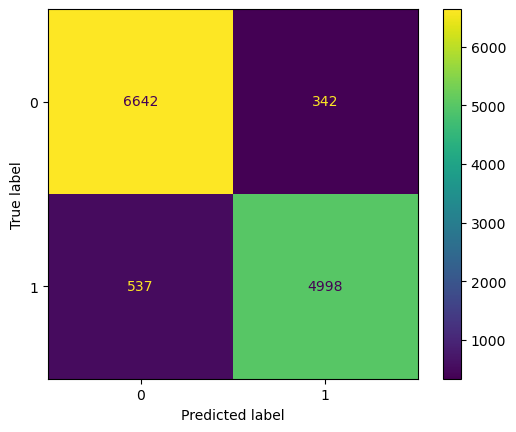

In [67]:
y_pred = roberta_rf.predict(x_test_fixed)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [68]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9297867241792476
Precision: 0.9359550561797753
Recall: 0.9029810298102982


## Results on test set

In [69]:
test_dataset = load_dataset("lelexuanzz/Gossipcop_Politifact_Test")
print(test_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'tfidf_embedding', 'bow_embedding', 'w2v_embedding', 'roberta_embedding'],
        num_rows: 6900
    })
})


In [72]:
test_df = test_dataset["train"].to_pandas()
display(test_df)


,text,label,tfidf_embedding,bow_embedding,w2v_embedding,roberta_embedding
0,The media reported on “5 TikTok dances you can...,0,"[0.32230591024075883, -0.028311949900530733, 0...","[4.111553694916485, -1.4091154149948346, -2.22...","[0.023112578, 0.004341462, -0.028385904, 0.039...","[-1.7613875, -0.29602507, 1.0549823, 0.4420643..."
1,"""Over 240,000 'unverified' ballots have alread...",0,"[0.3085783060828623, 0.11941719268786223, 0.04...","[15.340171294779958, 0.6782201913070947, -3.95...","[0.013536842, 0.009806181, 0.0037024287, 0.046...","[0.5113651, -0.5632596, -0.08679409, 0.0578204..."
2,"Says ""Ron Johnson is making excuses for rioter...",1,"[0.42330438481857957, 0.07862740950249068, 0.0...","[17.579511089264834, -3.370470538008803, -6.03...","[0.023063188, 0.059482925, 0.01734151, 0.06674...","[0.4061544, 0.033350937, -0.30923274, -0.04415..."
3,“We have seen over the last 10 years ... under...,0,"[0.3235193218432473, 0.1435034790001879, -0.01...","[13.623137823124184, 2.594215458815296, 1.1975...","[-0.03447485, 0.012470036, 0.040506534, 0.1266...","[0.74233645, -0.8022974, 0.30516905, -0.150992..."
4,“I don’t get involved in the hiring and firing...,0,"[0.21714023268741092, -0.013357531354942328, 0...","[11.715673205868814, -3.8977639951627094, -0.5...","[-0.039161813, 0.050845865, 0.045167223, -0.00...","[0.4902299, -0.04709744, -0.11096978, -0.33383..."
...,...,...,...,...,...,...
6895,Wedding Album: Dancing with the Stars Pro Lind...,0,"[0.14163919484467705, -0.1871535330863532, -0....","[0.5081918596591085, -0.4770132598925509, 0.04...","[0.007478841, 0.028465271, 0.01225586, 0.05277...","[-4.3445463, -0.82720375, -0.76975673, 0.55827..."
6896,WATCH: Sneak Peek: Arizona's Furious Alex Atta...,0,"[0.10089287837516506, -0.15370171061200275, -0...","[0.34453471754679216, -0.49345817220335975, 0....","[0.03495687, 0.08366224, 0.03197157, 0.0962388...","[-3.484783, -0.13741834, -0.2212331, 0.3501901..."
6897,Mary Kay Letourneau 'Hopeful' She Can Fix Marr...,0,"[0.30012685395650657, -0.2629061112392972, -0....","[5.587042723074881, -3.018912737323734, -0.696...","[0.0066373795, 0.04132683, 0.008552303, 0.0507...","[0.060427, 0.93066996, -0.5383188, -0.11787002..."
6898,Charlize Theron still upset Aeon Flux didn’t w...,0,"[0.18598375894521132, -0.26601918530104635, -0...","[1.8348212505816643, -2.5021137033474385, 0.45...","[0.032494266, 0.038722403, -0.01410776, 0.0764...","[0.29304072, 1.2304765, -0.0635877, 0.6557827,..."


## TF-IDF

In [73]:
y_test_set = test_df["label"]
x_test_set = test_df["tfidf_embedding"]
x_test_set_fixed = np.stack(x_test_set)
print(x_test_set_fixed.shape)

(6900, 300)


In [74]:
y_test_pred = tfidf_rf.predict(x_test_set_fixed)

In [75]:
accuracy = accuracy_score(y_test_set, y_test_pred)
precision = precision_score(y_test_set, y_test_pred)
recall = recall_score(y_test_set, y_test_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5807246376811595
Precision: 0.3419718309859155
Recall: 0.2602915951972556


## Bow

In [87]:
x_test_set = test_df["bow_embedding"]
x_test_set_fixed = np.stack(x_test_set)
print(x_test_set_fixed.shape)

(6900, 300)


In [88]:
y_test_pred = bow_rf.predict(x_test_set_fixed)

In [89]:
accuracy = accuracy_score(y_test_set, y_test_pred)
precision = precision_score(y_test_set, y_test_pred)
recall = recall_score(y_test_set, y_test_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.902463768115942
Precision: 0.940053050397878
Recall: 0.7598627787307033


## W2V

In [79]:
x_test_set = test_df["w2v_embedding"]
x_test_set_fixed = np.stack(x_test_set)
print(x_test_set_fixed.shape)

(6900, 300)


In [80]:
y_test_pred = w2v_rf.predict(x_test_set_fixed)

In [81]:
accuracy = accuracy_score(y_test_set, y_test_pred)
precision = precision_score(y_test_set, y_test_pred)
recall = recall_score(y_test_set, y_test_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.4071014492753623
Precision: 0.22660864159154492
Recall: 0.31260720411663806


## roBERTa (Iter 4)

In [82]:
x_test_set = test_df["roberta_embedding"]
x_test_set_fixed = np.stack(x_test_set)
print(x_test_set_fixed.shape)

(6900, 300)


In [85]:
y_test_pred = roberta_rf.predict(x_test_set_fixed)

In [86]:
accuracy = accuracy_score(y_test_set, y_test_pred)
precision = precision_score(y_test_set, y_test_pred)
recall = recall_score(y_test_set, y_test_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5872463768115942
Precision: 0.427811975377728
Recall: 0.6556603773584906


# save model

In [ ]:
# import pickle

# pickle.dump(tfidf_rf, open("models/iter3_rf_tfidf", 'wb'))
# pickle.dump(bow_rf, open("models/iter3_rf_bow", 'wb'))
# pickle.dump(w2v_rf, open("models/iter3_rf_w2v", 'wb'))
# pickle.dump(roberta_rf, open("models/iter4_rf_roberta", 'wb'))

Results are a lot worse for test set compared to validation set - shows that random forest model overfit to the training data. 

Do randomsearch again, but reduce model complexity.

In [ ]:
# #test to see if model can be loaded

# loaded_model = pickle.load(open('models/iter1_rf', 'rb'))

# load_predict = loaded_model.predict(x_test_set)

# accuracy = accuracy_score(y_test_set, load_predict)
# precision = precision_score(y_test_set, load_predict)
# recall = recall_score(y_test_set, load_predict)

# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)

Accuracy: 0.46144927536231883
Precision: 0.28128950695322374
Recall: 0.3816466552315609
